In [1]:
from dotenv import load_dotenv

load_dotenv()

from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_community.vectorstores import Chroma

embedding_function = GoogleGenerativeAIEmbeddings(model="models/embedding-001")


docs = [
    Document(
        page_content="Travories is a travel booking platform where travel agencies can create and list their tour packages. Tourists can browse and book these packages directly through the platform. Travories aims to connect travelers with a wide variety of curated travel experiences.",
        metadata={"source": "overview.txt"}
    ),
    Document(
        page_content="Travories is accessible 24 hours a day, 7 days a week, allowing both agencies and tourists to use the platform at their convenience, regardless of their time zone.",
        metadata={"source": "availability.txt"}
    ),
    Document(
        page_content="Travel agencies on Travories have the ability to create detailed descriptions of their tour packages, including itineraries, pricing, inclusions, and stunning visuals. They manage their own listings and availability.",
        metadata={"source": "agency_features.txt"}
    ),
    Document(
        page_content="Tourists using Travories can search for travel packages based on destination, interests, duration, and budget. They can view package details, read reviews (if available), and securely book their chosen tours through the platform.",
        metadata={"source": "tourist_features.txt"}
    ),
    Document(
        page_content="For any inquiries or support, users can contact Travories customer support via email at support@travories.com or through the live chat feature available on the website and mobile app.",
        metadata={"source": "support.txt"}
    ),
    Document(
        page_content="Travories supports various payment methods, including major credit cards, debit cards, and popular online payment gateways, ensuring a seamless booking experience for tourists worldwide.",
        metadata={"source": "payment.txt"}
    ),
]

db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 4})


/Users/prajwol/Documents/travories-geolocation/LangGraph/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

rag_chain = prompt | llm

In [11]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END


class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage


class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state

def question_classifier(state: AgentState):
    print("Entering question_classifier")

    system_message = SystemMessage(
        content="""You are a classifier that determines whether a user's question is about the services provided by Travories.

        Travories is a **travel booking platform** where travel agencies can create and list their tour packages, and tourists can browse and book these packages directly. Travories connects travelers with a wide variety of curated travel experiences.

        The topics include:
        1. Platform Overview and Purpose — General information about what Travories is, its mission, or how it connects tourists and agencies.
        2. Platform Availability — When and how the Travories platform can be accessed (e.g., 24/7 availability).
        3. Features for Travel Agencies — Capabilities offered to travel agencies such as creating packages, managing listings, adding visuals, setting pricing and availability.
        4. Features for Tourists — What tourists can do on Travories, including searching for packages, filtering by interest, reading descriptions or reviews, and making bookings.
        5. Customer Support — How users can contact Travories for help or inquiries (e.g., via email or live chat).
        6. Payment Methods — Supported methods for paying for tour packages on the platform.

        In addition, treat any question about:
        - Tour packages
        - Travel booking
        - Destinations, itinerary, or inclusions
        - Features of the Travories platform

        ...as **in scope**.

        If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.
        """
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )

    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})

    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state


class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )

def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"
    
def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state

def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(
        AIMessage(
            content="I'm sorry, but I cannot find the information you're looking for."
        )
    )
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state

In [12]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [13]:
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)
workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)

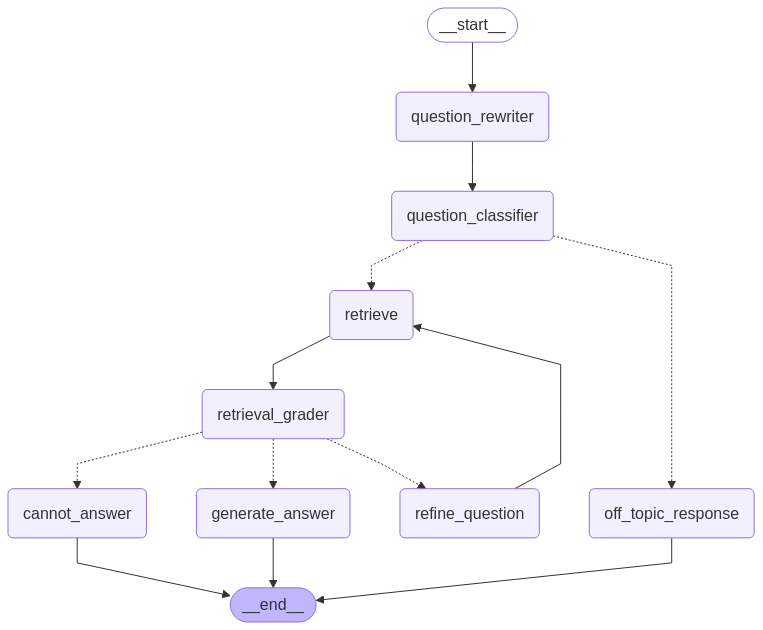

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Off Topic: 

In [15]:
input_data = {"question": HumanMessage(content="What does the company Apple do?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 100}})


Entering question_rewriter with following state: {'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response


{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'What does the company Apple do?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})}

No docs found

In [16]:
input_data = {
    "question": HumanMessage(
        content="What is the cancellation policy for tour bookings on Travories?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 101}})

Entering question_rewriter with following state: {'question': HumanMessage(content='What is the cancellation policy for tour bookings on Travories?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader
Grading document: Tourists using Travories can s... Result: No
Grading document: Travories supports various pay... Result: No
Grading document: For any inquiries or support, ... Result: No
Grading document: Travories is accessible 24 hou... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: What is Travories' cancellation policy for booked tours?
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader
Grading document: Tourists using Travories can s... Result: No
Grading docume

{'messages': [HumanMessage(content='What is the cancellation policy for tour bookings on Travories?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, but I cannot find the information you're looking for.", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': "What is Travories' cancellation policy for already booked tours, and what are the associated refund terms?",
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='What is the cancellation policy for tour bookings on Travories?', additional_kwargs={}, response_metadata={})}

Rag with History

In [17]:
input_data = {
    "question": HumanMessage(
        content="What is Travories and what does it do?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'question': HumanMessage(content='What is Travories and what does it do?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader
Grading document: Travories is a travel booking ... Result: Yes
Grading document: For any inquiries or support, ... Result: No
Grading document: Travories is accessible 24 hou... Result: Yes
Grading document: Travories supports various pay... Result: No
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: Based on the provided text, Travories is a travel booking platform.  It allows travel agencies to create and list their tour packages, and tourists to browse and book those packages directly.  The platform aims to connect travelers 

{'messages': [HumanMessage(content='What is Travories and what does it do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided text, Travories is a travel booking platform.  It allows travel agencies to create and list their tour packages, and tourists to browse and book those packages directly.  The platform aims to connect travelers with diverse, curated travel experiences and is accessible 24/7.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'overview.txt'}, page_content='Travories is a travel booking platform where travel agencies can create and list their tour packages. Tourists can browse and book these packages directly through the platform. Travories aims to connect travelers with a wide variety of curated travel experiences.'),
  Document(metadata={'source': 'availability.txt'}, page_content='Travories is accessible 24 hours a day, 7 days a week, allowing both agencies and tourists to use the pl

In [19]:
input_data = {
    "question": HumanMessage(
        content="When is it usually open for bookings?"
    )
}

graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What is Travories and what does it do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Based on the provided text, Travories is a travel booking platform.  It allows travel agencies to create and list their tour packages, and tourists to browse and book those packages directly.  The platform aims to connect travelers with diverse, curated travel experiences and is accessible 24/7.', additional_kwargs={}, response_metadata={}), HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'rephrased_question': 'When was Travories founded?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='When is it usually open for bookings?', additional_kwargs={}, response_metadata={})}
question

{'messages': [HumanMessage(content='What is Travories and what does it do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided text, Travories is a travel booking platform.  It allows travel agencies to create and list their tour packages, and tourists to browse and book those packages directly.  The platform aims to connect travelers with diverse, curated travel experiences and is accessible 24/7.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='When is it usually open for bookings?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided text in `availability.txt`, Travories is open for bookings 24 hours a day, 7 days a week.', additional_kwargs={}, response_metadata={})],
 'documents': [Docum